# Behavioral analysis of the SAflow MEG dataset

First, we need to compute the VTC (Variance Time Course) of every run.

In [145]:
import os
import os.path as op
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from saflow.behav import *
from saflow import LOGS_DIR
import pdb
import matplotlib.gridspec as gridspec

behav_path = "/home/hyruuk/GitHub/cc_saflow/data/behav/"
files_list = os.listdir(behav_path)
cpt_blocs = [2,3,4,5,6,7]
subject = '23'
bounds = [25,75]

def interpolate_RT(RT_raw):
    """Interpolates missing reaction times from the two nearest RTs.

    Parameters
    ----------
    RT_raw : np.array
        Raw reaction times as floats, with 0 for missing RT.

    Returns
    -------
    np.array
        The same array, but with 0s being replaced by the average of the two
        nearest RTs.

    """
    RT_array = RT_raw.copy()
    for idx, val in enumerate(RT_array):
        if val == 0:
            idx_next_val = 1
            try:
                while RT_array[idx + idx_next_val] == 0: # Find next non-zero value
                    idx_next_val += 1
                if idx == 0: # If first value is zero, use the next non-zero value
                    RT_array[idx] = RT_array[idx + idx_next_val]
                else: # else use the average of the two nearest non-zero
                    RT_array[idx] = RT_array[idx-1] + RT_array[idx + idx_next_val]
            except IndexError: # If end of file is reached, use the last non-zero
                RT_array[idx] = RT_array[idx-1]
    return RT_array

def compute_VTC(RT_array, subj_mean, subj_std):
    """Computes the raw (unfiltered) VTC.

    Parameters
    ----------
    RT_array : np.array
        Array of reaction times after interpolation.
    subj_mean : float
        Mean reaction time of a subject across all runs.
    subj_std : float
        Standard deviation of reaction times of a subject across all runs.

    Returns
    -------
    np.array
        Array containing VTC values, should be the same length as the RT array.

    """
    return abs((RT_array - subj_mean)/subj_std)

def clean_comerr(df_response):
    cleaned_df = df_response.copy()
    correct_omission_idx = []
    commission_error_idx = []
    correct_commission_idx = []
    omission_error_idx = []
    for idx_line, line in enumerate(cleaned_df.iterrows()):
        if line[1][0] == 1.0 and line[1][1] != 0.0: # Rare stim with response
            cleaned_df.loc[idx_line, 4] == 0.0
            commission_error_idx.append(idx_line)
        if line[1][0] == 1.0 and line[1][1] == 0.0: # Rare stim without response
            correct_omission_idx.append(idx_line)
        if line[1][0] == 2.0 and line[1][1] != 0.0: # Freq stim with response
            correct_commission_idx.append(idx_line)
        if line[1][0] == 2.0 and line[1][1] == 0.0: # Freq stim without response
            omission_error_idx.append(idx_line)
        
    performance_dict = {'commission_error':commission_error_idx,
                        'correct_omission':correct_omission_idx,
                        'omission_error':omission_error_idx,
                        'correct_commission':correct_commission_idx}
    return cleaned_df, performance_dict

def threshold_VTC(VTC, thresh=5):
    VTC[VTC >= thresh] = thresh
    return VTC

def get_VTC_from_file(
    subject, run, files_list, cpt_blocs=[2, 3, 4, 5, 6, 7], inout_bounds=[25, 75], filt_cutoff=0.05
):
    """Short summary.

    Parameters
    ----------
    subject : type
        Description of parameter `subject`.
    run : type
        Description of parameter `run`.
    files_list : type
        Description of parameter `files_list`.
    cpt_blocs : type
        Description of parameter `cpt_blocs`.
    inout_bounds : type
        Description of parameter `inout_bounds`.

    Returns
    -------
    type
        Description of returned object.

    """
    # Find the logfiles belonging to a subject
    subject_logfiles = []
    for bloc in cpt_blocs:
        subject_logfiles.append(
            op.join(behav_path, find_logfile(subject, bloc, files_list))
        )

    # Load and clean RT arrays
    RT_arrays = []
    RT_to_VTC = []
    for idx_file, logfile in enumerate(subject_logfiles):
        data = loadmat(logfile)
        df_response = pd.DataFrame(data["response"])
        
        # Replace commission errors by 0
        df_clean, perf_dict = clean_comerr(df_response)
        
        RT_raw = np.asarray(df_clean.loc[:, 4])
        RT_interpolated = interpolate_RT(RT_raw)
        RT_arrays.append(RT_interpolated)
        if int(cpt_blocs[idx_file]) == int(run):
            RT_to_VTC = RT_interpolated
            performance_dict = perf_dict
            df_response_out = df_response

    # Obtain meand and std across runs
    allruns_RT_array = np.concatenate(RT_arrays)
    subj_mean = np.mean(allruns_RT_array)
    subj_std = np.std(allruns_RT_array)

    # New VTC
    VTC_raw = compute_VTC(RT_to_VTC, subj_mean, subj_std)
    RT_clean = threshold_VTC(VTC_raw, thresh=3) # Remove variability values above threshold
    b, a = signal.butter(3, filt_cutoff)  # (filt_order,filt_cutoff)
    VTC_filtered = signal.filtfilt(b, a, VTC_raw)

    IN_mask = np.ma.masked_where(
        VTC_filtered >= np.quantile(VTC_filtered, inout_bounds[0] / 100), VTC_filtered
    )
    OUT_mask = np.ma.masked_where(
        VTC_filtered < np.quantile(VTC_filtered, inout_bounds[1] / 100), VTC_filtered
    )
    IN_idx = np.where(IN_mask.mask == False)[0]
    OUT_idx = np.where(OUT_mask.mask == False)[0]

    return IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response_out


def plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name='?', bloc='?', subgrid_axes=None, fig=None):
    if subgrid_axes == None:
        fig = plt.figure(figsize=(8,5))
        gs = fig.add_gridspec(4, hspace=0, wspace=0)
        ax_vtc = fig.add_subplot(gs[:3])
        ax_odd = fig.add_subplot(gs[3])
    else:
        subgrid_axes.set_xticks([])
        subgrid_axes.set_yticks([])
        gs_inner = gridspec.GridSpecFromSubplotSpec(4,1, hspace=0, wspace=0, subplot_spec=subgrid_axes)
        ax_vtc = fig.add_subplot(gs_inner[:3])
        ax_odd = fig.add_subplot(gs_inner[3])
        
    # VTC plot
    x = np.arange(0, len(VTC_raw))
    raw = ax_vtc.plot(x, VTC_raw)
    plt.setp(raw, linewidth=0.5, color='black')
    lines = ax_vtc.plot(x, IN_mask, x, OUT_mask)
    plt.setp(lines[0], linewidth=2, color='blue')
    plt.setp(lines[1], linewidth=2, color='orange')
    ax_vtc.legend(('VTC', 'IN zone', 'OUT zone'), loc='upper right')
    ax_vtc.set_title(f'VTC plot (sub-{subject_name}, run-0{bloc})')
    ax_vtc.set_ylabel('Standardized variance')

    # Oddball plot
    commission_error = performance_dict['commission_error']
    correct_omission = performance_dict['correct_omission']
    omission_error = performance_dict['omission_error']
    comerr = ax_odd.plot(commission_error, np.zeros(len(commission_error)), '*', color='red')
    corrom = ax_odd.plot(correct_omission, np.zeros(len(correct_omission))+1, '*', color='green')
    #omierr = ax_odd.plot(omission_error, np.zeros(len(omission_error))+2, '*', color='purple')
    ax_odd.set_ylim(-1,8)
    ax_odd.tick_params(left=False, labelleft=False)
    ax_odd.legend(('Commission error', 'Correct omission', 'Omission error'))
    ax_odd.set_xlabel('Trial')
    
    return fig, subgrid_axes

def subject_plot_VTC(subject):
    fig = plt.figure(figsize=(20,15))
    gs_outer = fig.add_gridspec(3, 2)
    for idx, grid in enumerate(gs_outer):
        subgrid_axes = fig.add_subplot(grid)
        IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict = get_VTC_from_file(subject, cpt_blocs[idx], files_list)
        plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name=subject, bloc=cpt_blocs[idx], subgrid_axes=subgrid_axes, fig=fig)
    return fig

In [146]:
test_array = np.array([1,2,3,4,5,6])
IN_mask = np.ma.masked_where(
    test_array >= 3, test_array
)
IN_idx = np.where(IN_mask.mask == False)[0]


In [147]:
IN_idx

array([0, 1])

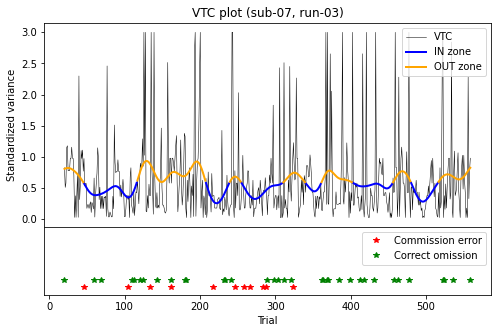

In [151]:
# Simple plot
subject = '07'
bloc = 3

IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, inout_bounds=inout_bounds)
plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask, performance_dict, subject_name=subject, bloc=bloc);

In [ ]:
np.where(IN_mask.mask == False)[0]

In [ ]:
# Subject-wise plots
from saflow import SUBJ_LIST

IMG_DIR = '/home/hyruuk/GitHub/cc_saflow/reports/figures/VTC_plots/'
os.makedirs(IMG_DIR, exist_ok=True)

for subject in SUBJ_LIST:
    fig = subject_plot_VTC(subject)
    fig_name = f'sub-{subject}_VTC_plots.png'
    fig.savefig(op.join(IMG_DIR, fig_name))
    plt.close()



In [149]:
from saflow import SUBJ_LIST
inout_bounds = [50,50]
filt_cutoff = 0.05

allsubj_lapserates = []


lapse_rates = []
omierr_rates = []
bloc_list = []
subject_list = []
cond_list = []
for subject in SUBJ_LIST:
    for bloc in [2,3,4,5,6,7]:
        IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask, performance_dict, df_response = get_VTC_from_file(subject, bloc, files_list, inout_bounds=inout_bounds)
        for loop_idx, inout_idx in enumerate([IN_idx, OUT_idx]):
            commission_error = [x for x in performance_dict['commission_error'] if x in inout_idx]
            omission_error = [x for x in performance_dict['omission_error'] if x in inout_idx]
            commission_correct = [x for x in performance_dict['correct_commission'] if x in inout_idx]
            omission_correct = [x for x in performance_dict['correct_omission'] if x in inout_idx]
            try:
                lapse_rate = len(commission_error) / (len(omission_correct) + len(commission_error))
            except ZeroDivisionError:
                lapse_rate = np.nan
            
            omierr_rate = len(omission_error) / (len(commission_correct) + len(omission_error))
            
            lapse_rates.append(lapse_rate)
            omierr_rates.append(omierr_rate)
            bloc_list.append(bloc)
            subject_list.append(subject)

            if loop_idx == 0:
                cond_list.append('IN')
            else:
                cond_list.append('OUT')
        

    

In [150]:
plot_df[plot_df['subject']=='07']

,lapse_rate,omierr_rate,subject,bloc,cond
36,0.571429,0.000000,07,2,IN
37,0.176471,0.032258,07,2,OUT
38,0.800000,0.000000,07,3,IN
39,0.125000,0.008065,07,3,OUT
40,0.250000,0.000000,07,4,IN
41,0.315789,0.008197,07,4,OUT
42,0.666667,0.000000,07,5,IN
43,0.368421,0.024590,07,5,OUT
44,0.692308,0.000000,07,6,IN
45,0.333333,0.016000,07,6,OUT


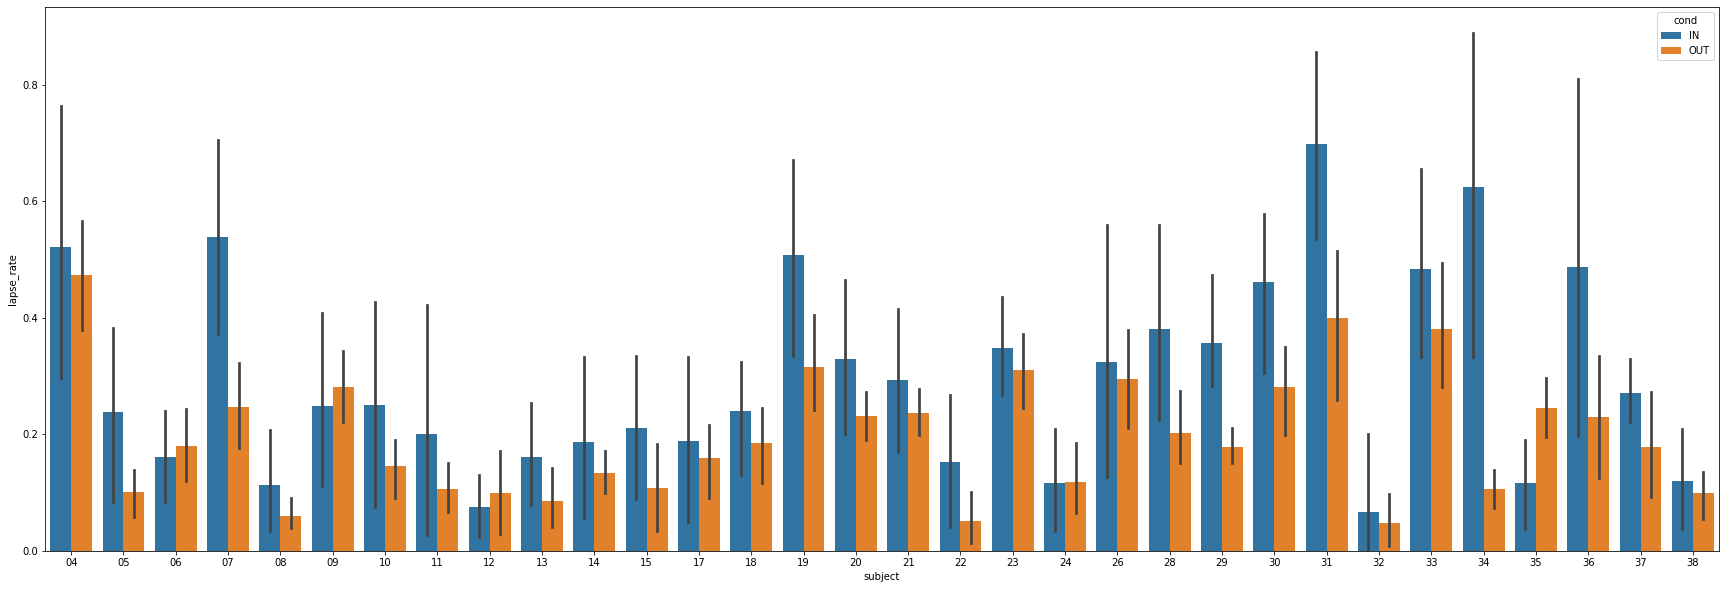

In [139]:
plot_df = pd.DataFrame({
    'lapse_rate':lapse_rates,
    'omierr_rate':omierr_rates,
    'subject':subject_list,
    'bloc':bloc_list,
    'cond':cond_list
})

import seaborn as sns

fig = plt.figure(figsize=(30,10))
ax = plt.subplot(1,1,1)
ax = sns.barplot(x="subject", hue='cond', y="lapse_rate", data=plot_df, ax=ax)

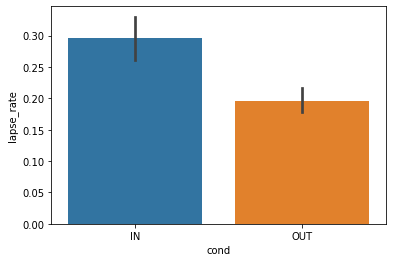

In [140]:
ax = sns.barplot(x="cond", y="lapse_rate", data=plot_df)